**Didn't work**

For creating a kernel with multiple threads:

```julia
using IJulia
installkernel("julia-8threads", env=Dict("JULIA_NUM_THREADS"=>"8"))
```

Deleting the kernel is as simple as deleting the folder containing it:

```julia
rm("/home/javier/.local/share/jupyter/kernels/julia-8threads-1.5", recursive=true)
```

In [2]:
# Error with scientific format in plot axes
ENV["GKS_ENCODING"] = "utf8"

using Plots
using Printf
using Statistics

using ProfileVega
ProfileVega.set_default_size(1200, 800)

# The default format SVG creates figures of size 9600x6400
gr(fmt="png")
nothing

In [3]:
using Revise

In [4]:
module CliffWalking

using ReinforcementLearningSutton.Commons: Point
using ReinforcementLearningSutton.GridWorld: GameGridWorldStatic, StateGridWorldStatic, ActionGridWorldStatic, restart, state, state_set, ncols, nrows
import ReinforcementLearningSutton.GridWorld: update

struct Cliff
    track::Array{Bool, 2}
    penalty::Int
end

function update(game::GameGridWorldStatic{Cliff}, action::ActionGridWorldStatic)::Int
    cliff = game.ruleset
    s0 = state(game)
    
    pos_x = max(1, min(s0.pos.x + action.move.x, ncols(game)))
    pos_y = max(1, min(s0.pos.y + action.move.y, nrows(game)))
    penalty = ifelse(cliff.track[pos_y, pos_x], cliff.penalty, -1)
    
    if penalty < -1
        restart(game)
    else
        s = StateGridWorldStatic(nrows(game), ncols(game), Point(pos_x, pos_y))
        state_set(game, s)
    end
    penalty
end

end

┌ Info: Precompiling ReinforcementLearningSutton [6417796d-59bf-4f93-aaf0-e2be7741ea64]
└ @ Base loading.jl:1278


Main.CliffWalking

In [5]:
using ReinforcementLearningSutton.Commons: LearningSarsa, LearningSarsaExpected, LearningQ, PlayerεGreedy, Point, play_game
using ReinforcementLearningSutton.GridWorld: GameGridWorldStaticBase, GameGridWorldStatic

In [6]:
nrows = 4
ncols = 12
pos_start = Point(1, nrows)
pos_goal = Point(ncols, nrows)

allowed_movements = "cross"

cliff_track = zeros(Bool, nrows, ncols)
cliff_track[nrows, 2:(ncols-1)] .= true
cliff = CliffWalking.Cliff(cliff_track, -100)

game0 = GameGridWorldStaticBase(nrows, ncols, pos_start, pos_goal, allowed_movements)
game = GameGridWorldStatic(game0, cliff)

GameGridWorldStatic{Main.CliffWalking.Cliff}(GameGridWorldStaticBase(4, 12, Base.RefValue{ReinforcementLearningSutton.GridWorld.StateGridWorldStatic}(State(pos=(1, 4))), State(pos=(1, 4)), State(pos=(12, 4)), "cross", ReinforcementLearningSutton.GridWorld.ActionGridWorldStatic[ReinforcementLearningSutton.GridWorld.ActionGridWorldStatic((1, 0), 1), ReinforcementLearningSutton.GridWorld.ActionGridWorldStatic((0, 1), 2), ReinforcementLearningSutton.GridWorld.ActionGridWorldStatic((-1, 0), 3), ReinforcementLearningSutton.GridWorld.ActionGridWorldStatic((0, -1), 4)]), Main.CliffWalking.Cliff(Bool[0 0 … 0 0; 0 0 … 0 0; 0 0 … 0 0; 0 1 … 1 0], -100))

### Single parameter comparison

In [6]:
ε = 0.1
α = 0.5
γ = 1.0

max_nsteps = 1000
ngames = 100000
nothing

#### Sarsa

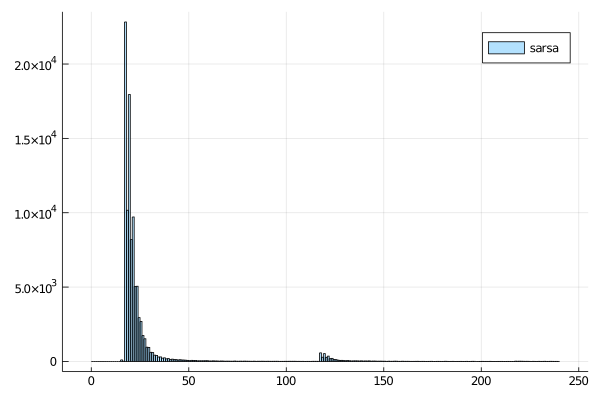

In [13]:
player = PlayerεGreedy(game, ε)
learning = LearningSarsa(player, α, γ)

results_sarsa = -[play_game(game, player, max_nsteps, learning) for _ in 1:ngames]

histogram(results_sarsa, bins=0:1:240, fillalpha=0.3, label=reshape(["sarsa"], 1, :))

In [8]:
mean(results_sarsa)

26.86608

#### Q-learning

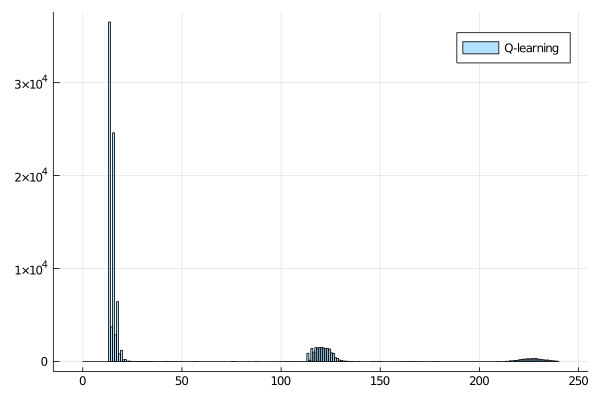

In [12]:
player = PlayerεGreedy(game, ε)
learning = LearningQ(player, α, γ)

results_q = -[play_game(game, player, max_nsteps, learning) for _ in 1:ngames]

histogram(results_q, bins=0:1:240, fillalpha=0.3, label=reshape(["Q-learning"], 1, :))

In [10]:
mean(results_q)

46.73756

### Comparison of Sarsa, Q-learning and expected Sarsa

Asymptotic values:

In [7]:
ε = 0.1
αs = 0.1:0.05:1
γ = 1.0

In [30]:
nrounds = 10
ngames = 100000
max_nsteps = 10000

results_asymptotic = Dict{Tuple{String, Float64}, Array{Float64, 1}}()

for (learning_algo_lbl, learning_algo) in [("Sarsa", LearningSarsa),
                                           ("Q", LearningQ),
                                           ("Expected Sarsa", LearningSarsaExpected)]
    println(learning_algo_lbl)
    for α in αs
        results_asymptotic[(learning_algo_lbl, α)] = Array{Float64, 1}(undef, nrounds)
        for nround in 1:nrounds
            player = PlayerεGreedy(game, ε)
            learning = learning_algo(player, α, γ)
            outcomes = [play_game(game, player, max_nsteps, learning) for _ in 1:ngames]
            results_asymptotic[(learning_algo_lbl, α)][nround] = mean(outcomes)
        end
    end
end

Sarsa
Q
Expected Sarsa


In [9]:
nrounds = 50000
ngames = 100
max_nsteps = 10000

results = Dict{Tuple{String, Float64}, Array{Float64, 1}}()

for (learning_algo_lbl, learning_algo) in [("Sarsa", LearningSarsa),
                                           ("Q", LearningQ),
                                           ("Expected Sarsa", LearningSarsaExpected)]
    println(learning_algo_lbl)
    for α in αs
        results[(learning_algo_lbl, α)] = Array{Float64, 1}(undef, nrounds)
        for nround in 1:nrounds
            player = PlayerεGreedy(game, ε)
            learning = learning_algo(player, α, γ)
            outcomes = [play_game(game, player, max_nsteps, learning) for _ in 1:ngames]
            results[(learning_algo_lbl, α)][nround] = mean(outcomes)
        end
    end
end

Sarsa
Q
Expected Sarsa


In [31]:
results_summ = Array{Float64, 2}(undef, length(αs), 6)
for (i, learning_algo_lbl) in enumerate(["Sarsa", "Q", "Expected Sarsa"])
    for (j, α) in enumerate(αs)
        results_summ[j, i] = mean(results[(learning_algo_lbl, α)])
        results_summ[j, i + 3] = mean(results_asymptotic[(learning_algo_lbl, α)])
    end
end

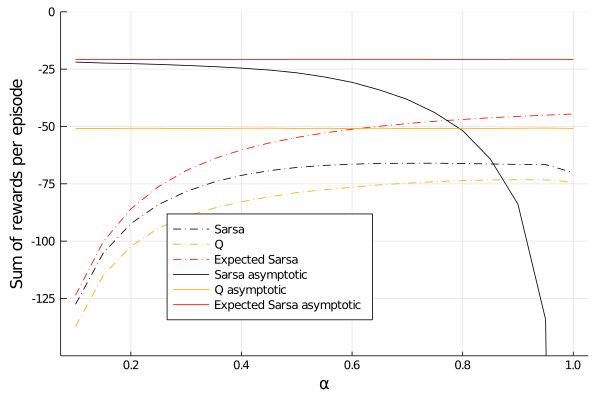

In [43]:
plot(αs, results_summ,
     label=["Sarsa" "Q" "Expected Sarsa" "Sarsa asymptotic" "Q asymptotic" "Expected Sarsa asymptotic"],
     color = [:black :orange :red],
     linestyle = [:dashdot :dashdot :dashdot :solid :solid :solid],
     legend=:bottom,
     xlabel="α",
     ylabel="Sum of rewards per episode")
ylims!((-150, 0))

#### Timing and profiling

In [77]:
α = 0.1
learning_algo = LearningSarsa
player = PlayerεGreedy(game, ε)
learning = learning_algo(player, α, γ)
play_game(game, player, max_nsteps, learning)
@time [play_game(game, player, max_nsteps, learning) for _ in 1:ngames]
nothing

  0.134503 seconds (75.73 k allocations: 4.510 MiB)


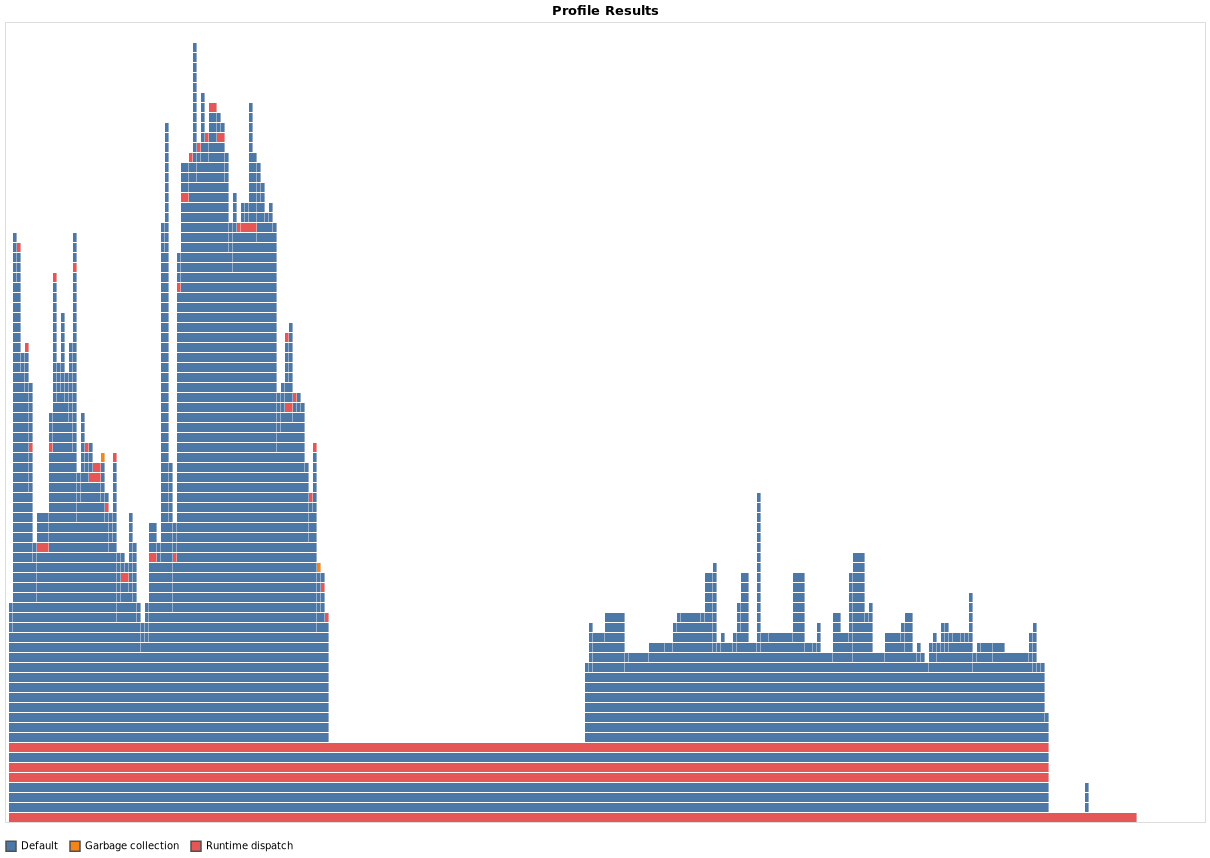

In [75]:
function f(game, player, max_nsteps, learning, ngames)
    [play_game(game, player, max_nsteps, learning) for _ in 1:ngames]
end

α = 0.1
learning_algo = LearningSarsa
player = PlayerεGreedy(game, ε)
learning = learning_algo(player, α, γ)
play_game(game, player, max_nsteps, learning)
@profview f(game, player, max_nsteps, learning, ngames)